In [1]:
# reload modules automatically
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from pathlib import Path

import matplotlib.pyplot as plt

# load any variables defined in the .env file
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv());

In [3]:
from convio.convio import ConvIO

# CRQA - Face happiness between two participants

This notebook shows how to get started looking at CRQA

This is an example of using the [PyRQA package](https://pypi.org/project/PyRQA/) to analyze recurrence in two time series for separate speakers in our conversations.

In [4]:
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.computing_type import ComputingType
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.computation import RPComputation
from pyrqa.image_generator import ImageGenerator

First we'll load the features for each conversation turn and then selected `prob_face_happiness`, which is the probability [0, 1] that our models identifies a particular user's face as happy. We then use `unstack` to move the user_id in the multindex into the columns instead.

In [5]:
convo = ConvIO(
    "s3://betterup-conv-analysis/processed/59a6e619-7cb7-498e-8f8a-3f609616ca43",
)

In [18]:
convo.transcript_df

,speaker,start,stop,utterance,backchannel,backchannel_count,backchannel_speaker,backchannel_start,backchannel_stop,spacy_doc,pause,delta,questions,end_question,overlap,n_words
turn_id,,,,,,,,,,,,,,,,
0,58431,47.74,48.30,Hi.,,0,None,NaN,NaN,"(Hi, .)",NaN,0.56,0,False,False,1
1,49206,48.44,50.85,"Hiking, Yuri. Great.","Yeah, Big",1,58431,49.70,50.57,"(Hiking, ,, Yuri, ., Great, .)",0.14,2.41,0,False,False,3
2,58431,50.57,50.97,here.,,0,None,NaN,NaN,"(here, .)",-0.28,0.40,0,False,True,1
3,49206,51.34,60.85,Okay. Hi. So I guess you could start a convers...,,0,None,NaN,NaN,"(Okay, ., Hi, ., So, I, guess, you, could, sta...",0.37,9.51,0,False,False,19
4,58431,61.54,63.13,"Yeah, I am Naveen",,0,None,NaN,NaN,"(Yeah, ,, I, am, Naveen)",0.69,1.59,0,False,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,58431,1823.04,1828.58,"named. So Yeah, he's talking",,0,None,NaN,NaN,"(named, ., So, Yeah, ,, he, 's, talking)",-4.23,5.54,0,False,True,6
283,49206,1828.44,1828.74,I have no,,0,None,NaN,NaN,"(I, have, no)",-0.14,0.30,0,False,False,3
284,58431,1828.59,1828.95,to you.,,0,None,NaN,NaN,"(to, you, .)",-0.15,0.36,0,False,False,2


In [6]:
df = convo.feature_df_turns
df['prob_face_happiness'].unstack()

user_id,49206,58431
turn_ix,,
-1.0,0.189620,NaN
0.0,0.701857,NaN
1.0,0.805301,NaN
2.0,0.531885,NaN
3.0,0.549451,NaN
...,...,...
278.0,0.538105,0.099954
280.0,0.879157,0.009078
282.0,0.671960,0.086958


We set up the 

In some work, we saw that people would optimize the hyperparameters to the maximum recurrence rate. It's not immediately clear that approaching the problem with different parameters for different conversations would lead to more 

In [7]:
def calculate_recurrence(data, column_name, normalize=True, fillna=True):
    data_x = data[column_name].unstack().iloc[:, 0]
    data_y = data[column_name].unstack().iloc[:, 1]
    
    if normalize:
        data_x = (data_x - data_x.mean()) / data_x.std()
        data_y = (data_y - data_y.mean()) / data_y.std()

    if fillna:
        data_x.fillna(data_x.mean())
        data_y.fillna(data_y.mean())
        
    time_series_x = TimeSeries(data_x,
                               embedding_dimension=2,
                               time_delay=2)

    time_series_y = TimeSeries(data_y,
                               embedding_dimension=2,
                               time_delay=2)

    time_series = (time_series_x,
                   time_series_y)

    settings = Settings(
        time_series,
        computing_type=ComputingType.Cross,
        neighbourhood=FixedRadius(0.75),
        similarity_measure=EuclideanMetric,
        theiler_corrector=0
    )

    computation = RQAComputation.create(settings)
    result = computation.run()

    return result, settings

res, settings = calculate_recurrence(df, "prob_face_happiness")
print(res)

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.136253
Determinism (DET): 0.265898
Average diagonal line length (L): 2.653188
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 1.075395
Laminarity (LAM): 0.748286
Trapping time (TT): 4.908998
Longest vertical line length (V_max): 22
Entropy vertical lines (V_entr): 2.048870
Average white vertical line length (W): 20.503345
Longest white vertical line length (W_max): 217
Longest white vertical line length inverse (W_div): 0.004608
Entropy white vertical lines (W_entr): 3.442258

Ratio determinism / recurrence rate (DET/RR): 1.951506
Ratio laminarity / determinism (LAM/DET): 2.814185



Here are some additional resources on recurrence plots and CRQA:

- [Backgound information on interpreting recurrence plots](http://www.recurrence-plot.tk/glance.php)
- [Example CRQA analysis](https://www.frontiersin.org/articles/10.3389/fpsyg.2018.02232/full#B9)

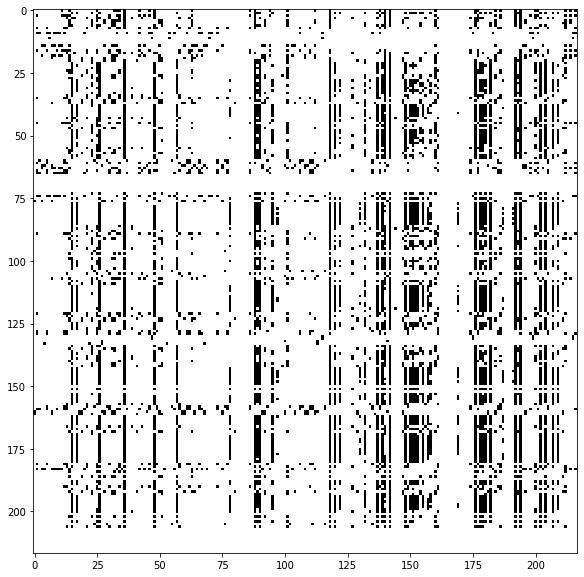

In [8]:
from pyrqa.computation import RPComputation
from pyrqa.image_generator import ImageGenerator

computation = RPComputation.create(settings)
result = computation.run()

img = ImageGenerator.generate_recurrence_plot(result.recurrence_matrix_reverse)

plt.imshow(img)
fig = plt.gcf()
fig.set_size_inches((10, 10))

## Calculating recurrence rate across multiple conversations

In [9]:
convo_list = ConvIO.load_conversations(
   's3://betterup-conv-analysis/processed/',
)

100%|██████████| 144/144 [03:52<00:00,  1.62s/it]


In [10]:
%%time

# load the `feature_df_time` property for all convos, and join them
all_features = ConvIO.join_convo_dfs(convo_list, 'feature_df_turns')

 12%|█▎        | 17/136 [02:13<13:05,  6.60s/it]/Users/bull/code/betterup-convo-pipeline/convio/convio.py:807: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(audio_dfs).reset_index().set_index(["timedelta", "user_id"])
100%|██████████| 136/136 [17:24<00:00,  7.68s/it]

CPU times: user 6min 30s, sys: 6.99 s, total: 6min 37s
Wall time: 17min 24s



/Users/bull/code/betterup-convo-pipeline/convio/convio.py:641: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(dfs, keys=ids, names=["conversation_id"])


In [12]:
# apply the recurrence calculation to every conversation
all_features.groupby('conversation_id').apply(
    lambda x: calculate_recurrence(x, "prob_face_happiness")[0].recurrence_rate
).sort_values()

conversation_id
b3878b24-e319-48a2-9a0c-813f9c5e0336    0.002501
77604c00-f69b-48ad-9923-03c26872f1c9    0.004518
45076db4-cf24-4c3d-81ba-0bd5e3d7d110    0.022141
2fead516-9c8a-47be-a7d1-197091154cd1    0.028106
deea9e23-92e1-4d88-b230-dd94ba04b8f0    0.028294
                                          ...   
4717ed52-4beb-4f68-87fd-f4df224205e8    0.282563
e8a65cda-55e5-47d2-b895-1e0ac20eba80    0.285312
a49bf61e-af9f-437d-9864-27910582b86d    0.298396
6254ff23-b19b-4bc5-860d-7d9dca3c6132    0.302629
7193181e-85e5-4c31-96f7-d4f38c312f71    0.320173
Length: 136, dtype: float64

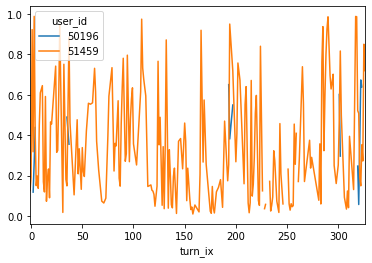

In [13]:
least_recurr_features = (
    all_features[
        all_features.index.get_level_values('conversation_id') == \
        'b3878b24-e319-48a2-9a0c-813f9c5e0336'
    ]
)

least_recurr_features.prob_face_happiness.unstack().droplevel(0).plot()


In [14]:
least_recurr = ConvIO(
    's3://betterup-conv-analysis/processed/b3878b24-e319-48a2-9a0c-813f9c5e0336'
)

least_recurr.video_widget

This seems to be an outlier where the lighting, skin tone, and position of the speaker on the left mean that we don't have a good view of her face. Because of this we have very few observations, so very little cross-recurrence. 

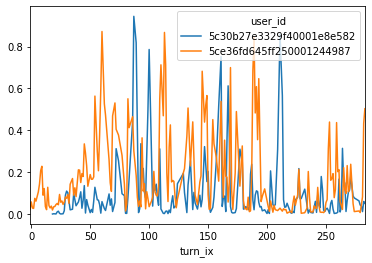

In [16]:
most_recurr_features = (
    all_features[
        all_features.index.get_level_values('conversation_id') == \
        '7193181e-85e5-4c31-96f7-d4f38c312f71'
    ]
)

most_recurr_features.prob_face_happiness.unstack().droplevel(0).plot()


In [17]:
most_recurr = ConvIO(
    's3://betterup-conv-analysis/processed/7193181e-85e5-4c31-96f7-d4f38c312f71'
)

most_recurr.video_widget